<a href="https://colab.research.google.com/github/VM-Janani/Stone-Segmentation/blob/main/Stone_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import the libraries and load the dataset

In [ ]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
#function to load the data set and make image and mask lists

def load_dataset(directory):
    # Initilaize the lists to store image and masks
    images = []
    masks = []

    # Iterate over all the files in the directory
    for filename in os.listdir(directory):

        # check if the file is an JPG image
        if filename.endswith(".JPG"):
            image_path = os.path.join(directory, filename)
            mask_path = os.path.join(directory, filename.split('.')[0] + '_label.jpg')

            # Load image
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Assuming mask is grayscale

            # Resize image and mask
            target_size = (256,256)
            image_resized = cv2.resize(image, target_size)
            mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

            # Append to lists
            images.append(np.array(image_resized))
            masks.append(np.array(mask_resized))

    return images, masks


dataset_directory = "/content/drive/MyDrive/datasets/Dataset"  # the data set directory
image_dataset1, mask_dataset1 = load_dataset(dataset_directory)

In [ ]:
import cv2
import numpy as np

# Function to convert a list of 3-channel images to grayscale
def convert_to_grayscale(image_dataset1):
    grayscale_images = []
    for image in image_dataset1:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grayscale_images.append(gray_image)
    return np.array(grayscale_images)

# Assuming normalized_images is your list of 3-channel images
grayscale_images = convert_to_grayscale(image_dataset1)


##Normalization

In [ ]:
#Normalize images
normalized_images = normalize(grayscale_images, axis=1)

image_dataset = np.expand_dims(normalize(np.array(normalized_images),axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset1)),3) /255.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.2, random_state = 2)

In [ ]:
# Check the sizes of each set
print(f"Training set: {len(X_train)} images, {len(y_train)} masks")
#print(f"Validation set: {len(val_images)} images, {len(val_masks)} masks")
print(f"Testing set: {len(X_test)} images, {len(y_test)} masks")
X_train.shape, y_train.shape

Training set: 16 images, 16 masks
Testing set: 4 images, 4 masks


((16, 256, 256, 1), (16, 256, 256, 1))

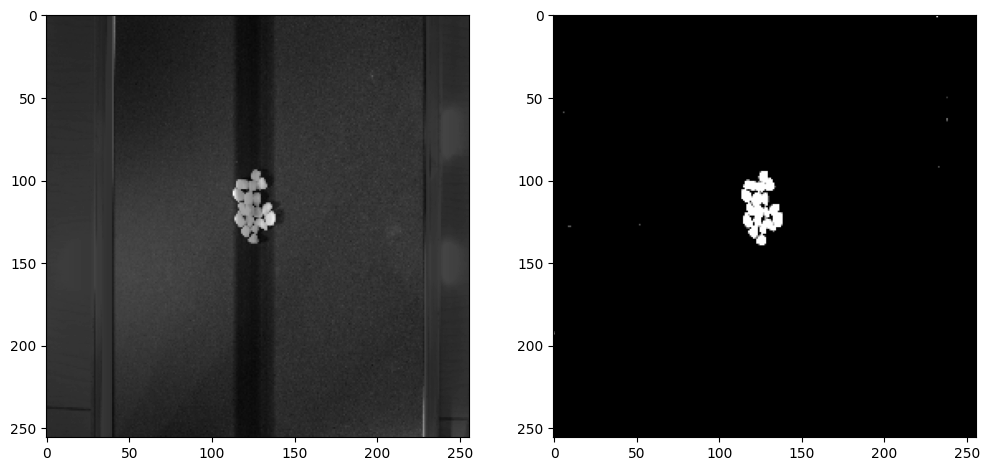

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

##Data augmentation

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

# Define augmentation pipeline
def augment_data(images, masks, target_size=(256, 256), num_augments=5):
    augmentation_pipeline = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, p=0.5),
        A.GridDistortion(p=0.2),
        A.GaussianBlur(p=0.2),
        A.Rotate(limit=40, p=0.5),
        A.RandomScale(scale_limit=0.2, p=0.5),
        A.Resize(height=target_size[0], width=target_size[1]),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=None, p=0.2),
        ToTensorV2()
    ])

    augmented_images = []
    augmented_masks = []

    for img, mask in zip(images, masks):
        for _ in range(num_augments):
            augmented = augmentation_pipeline(image=img, mask=mask)

            # Correct the mask shape explicitly
            augmented_image = augmented['image'].numpy().transpose(1, 2, 0)  # Shape (256, 256, 1)
            augmented_mask = augmented['mask'].numpy().squeeze()  # Remove any extra dimensions

            # Ensure the mask shape is correct
            if augmented_mask.shape == (256, 256):
                augmented_mask = np.reshape(augmented_mask, (256, 256, 1))  # Reshape to (256, 256, 1)

            augmented_images.append(augmented_image)
            augmented_masks.append(augmented_mask)

    return np.array(augmented_images), np.array(augmented_masks)

In [ ]:
X_train, y_train = augment_data(X_train, y_train)

In [ ]:
X_train.shape, y_train.shape

((80, 256, 256, 1), (80, 256, 256, 1))

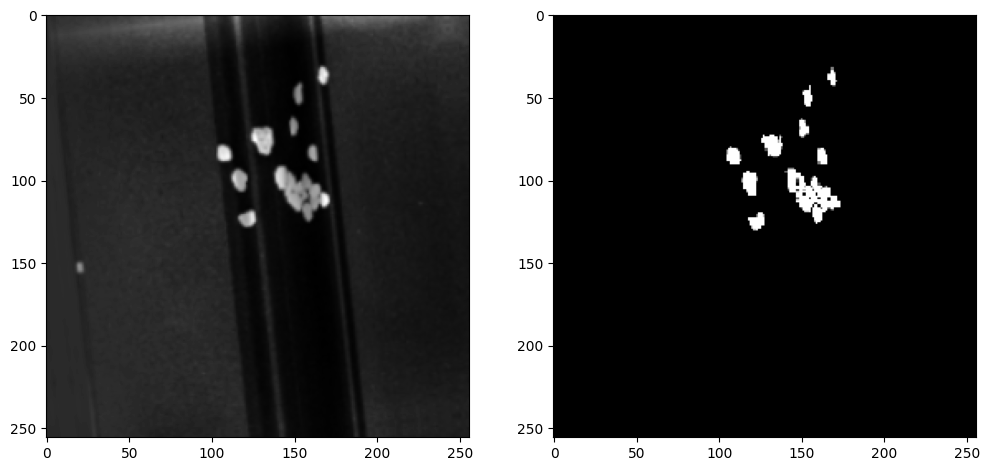

In [ ]:
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

##Model building

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [ ]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model


In [ ]:
model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

##Training the model

In [ ]:
# Define early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 4,
                    verbose=1,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks=[early_stopping])


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9854 - loss: 0.0270 - val_accuracy: 0.9923 - val_loss: 0.0131
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.9855 - loss: 0.0273 - val_accuracy: 0.9923 - val_loss: 0.0134
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9855 - loss: 0.0267 - val_accuracy: 0.9923 - val_loss: 0.0133
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9855 - loss: 0.0267 - val_accuracy: 0.9922 - val_loss: 0.0135
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9857 - loss: 0.0261 - val_accuracy: 0.9922 - val_loss: 0.0132
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.9857 - loss: 0.0260 - val_accuracy: 0.9922 - val_loss: 0.0133


In [ ]:
# Save the model
model_save_path = '/content/drive/MyDrive/model/unet_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/model/unet_model.h5


In [ ]:
	# evaluate model
_,acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step - accuracy: 0.9923 - loss: 0.0131
Accuracy =  99.22523498535156 %


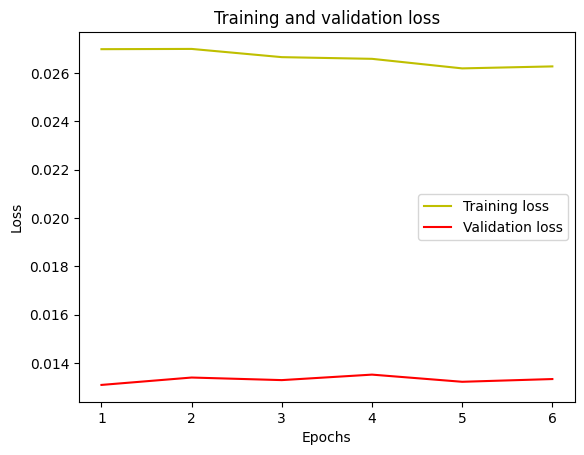

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#IOU score
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5
intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
IoU socre is:  0.75850838625631


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


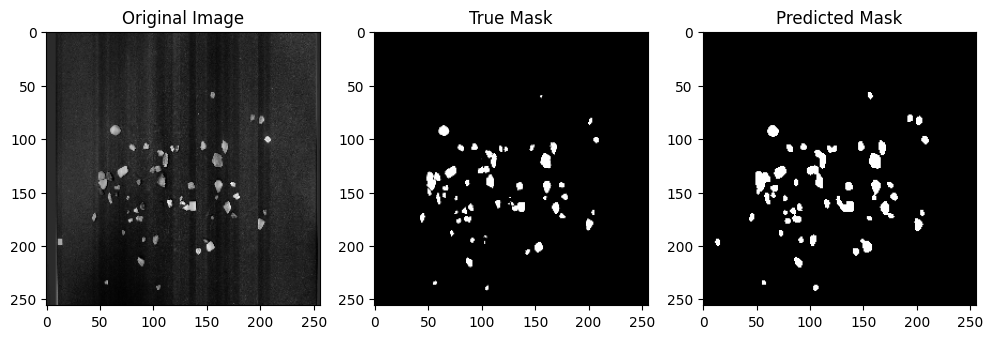

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


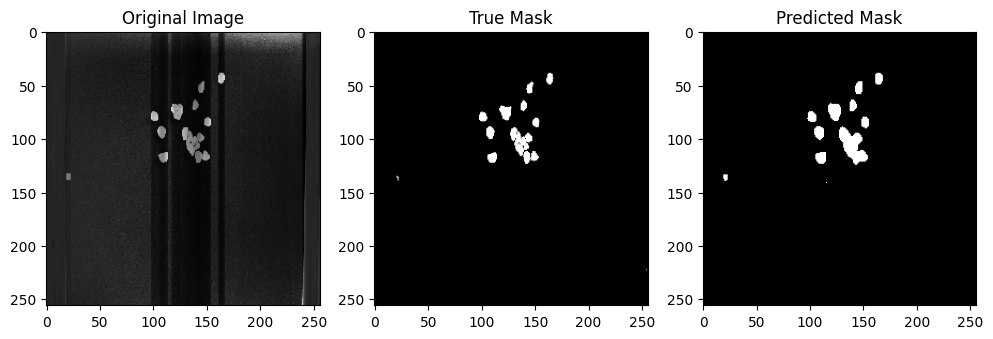

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


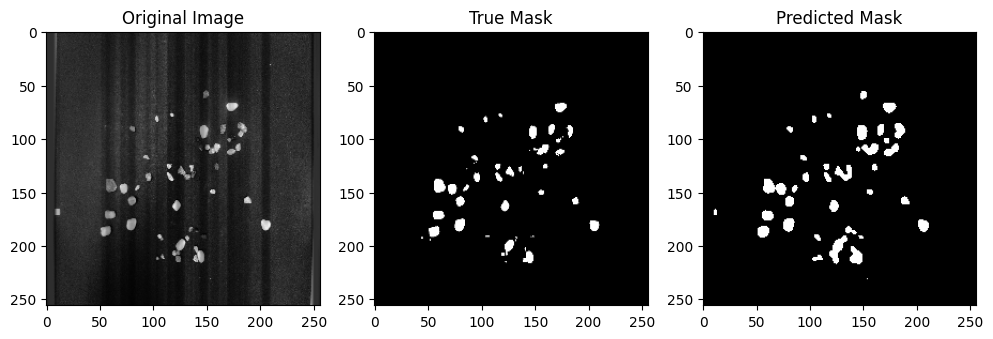

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


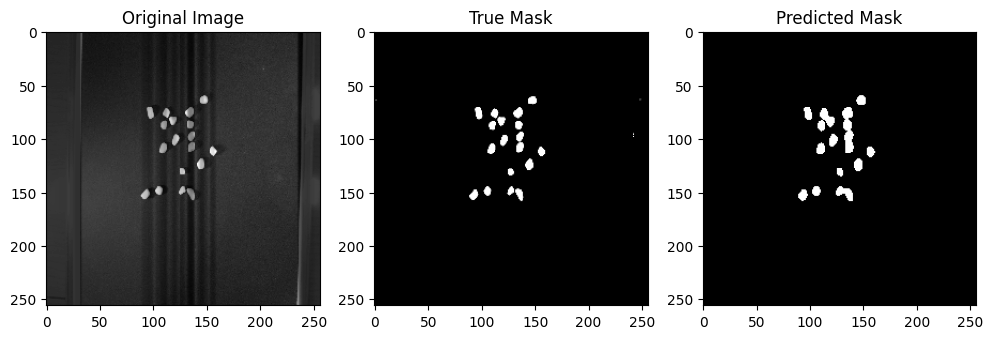

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to predict and plot the results
def predict_and_plot_all(model, X_test, y_test):
    num_test_images = len(X_test)

    for i in range(num_test_images):
        test_img = X_test[i]
        ground_truth = y_test[i]

        # Prepare the test image for prediction
        test_img_input = np.expand_dims(test_img, 0)

        # Predict the mask
        prediction = (model.predict(test_img_input)[0, :, :, 0] > 0.2).astype(np.uint8)

        # Plotting the original test image, ground truth mask, and the predicted mask
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(test_img.squeeze(), cmap='gray')
        plt.title('Original Image')

        # True Mask
        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth.squeeze(), cmap='gray')
        plt.title('True Mask')

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(prediction, cmap='gray')
        plt.title('Predicted Mask')

        plt.show()

# Call the function to predict and plot results for all test images
predict_and_plot_all(model, X_test, y_test)


Pridiction on different image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


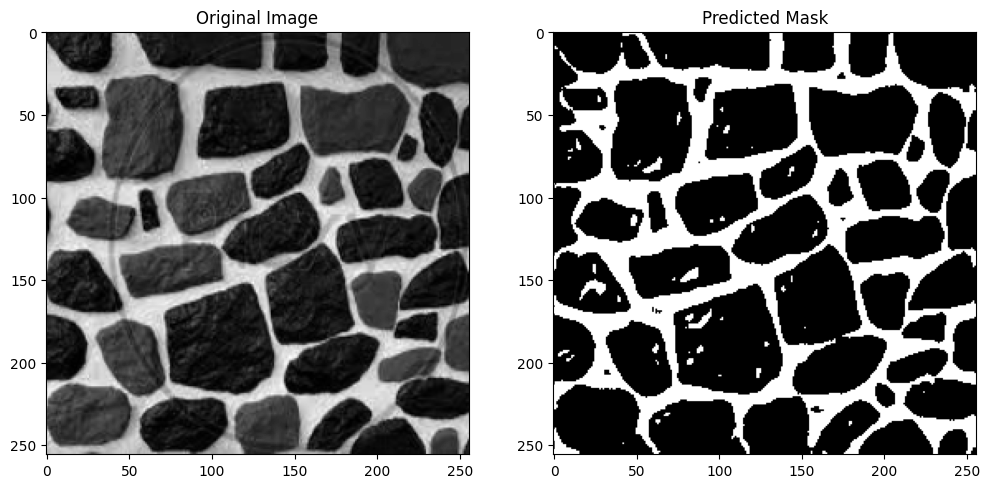

In [ ]:
# Path to the image file in Google Drive
image_path = '/content/drive/MyDrive/testdata/testing1.jpg'

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=(0, -1))  # Add batch and channel dimensions
    return image

# Load the image
test_img = load_and_preprocess_image(image_path)

# Predict the mask
prediction = (model.predict(test_img)[0, :, :, 0] > 0.5).astype(np.uint8)

# Visualize the result
def visualize_prediction(test_img, prediction):
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(test_img.squeeze(), cmap='gray')
    plt.title('Original Image')

    # Predicted Mask
    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

# Call the visualization function
visualize_prediction(test_img.squeeze(), prediction)